## Part 1: random recipe generator##
1. uniform random copy mutate model
2. frequency-preserving copy mutate model
3. uniform random (uniform random sampling)

### Difference between 1 and 2 ###
- 1 - no fitness value, the mutate process don't compare fitness value
- 2 - has fitness value based on spice usage frequency, need to compare fitness value before mutate

In [2]:
import json
import numpy as np
import random
from Graph_Helpers import *
from MinSetCover import *

In [3]:
result_folder = 'Derived_Data/CopyMutate/'
cuisinerecipe2spicerecipe_orig = json2dict('Derived_Data/Overlap/cuisinerecipe2spicerecipe_combined.json')
print(len(cuisinerecipe2spicerecipe_orig))

5636


In [4]:
def countdict_stats(d):
    s_counts = list(d.values())
    max_count = max(s_counts)
    min_count = min(s_counts)
    avg_count = np.mean(s_counts)
    median_count = np.median(s_counts)
    print('max:', max_count, 'min:', min_count, 'mean:', avg_count, 'median:', median_count)

r2s_count_combined = dict2countdict(cuisinerecipe2spicerecipe_orig, list(cuisinerecipe2spicerecipe_orig.keys()))

print('Tarla + Sanjeev:')
countdict_stats(r2s_count_combined)


Tarla + Sanjeev:
max: 24 min: 1 mean: 6.6320085166784954 median: 6.0


### Model 1: Uniform Random Copy Mutate ###

In [5]:
# UNIFORM RANDOM 
# Random recipe generator with Copy Mutate Algorithm

# s: spice ingredients r: recipe

def copy_mutate_uniformrand(r2s_orig, r_pool_count=20, s_count=7, s_pool_count=10, M=6, ratio_threshold=0.2):
    '''
    Args: 
        r2s_orig - original r2s dictionary
        
        r_pool_count - initial number of r(recipe) in r_pool, will be updated
        
        s_count - number of s(spice) per one recipe 
        (QUESTION: is s_count a fixed value? is every random recipe contain same number of spices?)
        
        s_pool_count - initial number of s(spice) in s_pool, will be updated 
        
        M - number of mutations per time step
        
        ratio_threshold - threshold to maintain and add s(spice) to s_pool if s2r_ratio below threshold. 
        (QUESTION: what value should ratio_threshold take?)
    
    Return: random recipe sets
    '''
    s_orig = list(set(list(chain.from_iterable(r2s_orig.values())))) # all spices
    print('# of spices:', len(s_orig))
    r_orig = list(r2s_orig.keys()) # all recipes
    s_orig_count = len(s_orig) # number of all spices
    r_orig_count = len(r_orig) # number of all recipes

    # keep track of remaining spice collection
    # initially contains all spices encoded by number
    s_orig_coded = list(range(0,s_orig_count)) 

    s_pool = random.sample(s_orig_coded, s_pool_count) # initialize s_pool with #s_pool_count of spices randomly selected

    # remove spice in s_pool from original spice collection (i.e. s_orig_coded)
    for s in s_pool:
        s_orig_coded.remove(s) 

    # generate initial recipe pool (i.e. r_pool)
    # initialize a list of #r_pool_count of recipes, each containing #s_count of spices randomly selected from s_pool
    r_pool = []
    count = 0
    while(1):
        r_rand = random.sample(s_pool, s_count)
        r_rand.sort()
        if count == r_pool_count:
            break
        if r_rand not in r_pool:
            r_pool.append(r_rand)
            count += 1

    r_pool_orig = r_pool.copy()

    #ratio_threshold = s_pool_count/r_pool_count   
    
    #random.seed(seed)
    random.seed()

    while(1):# time step
        if len(r_pool) == r_orig_count:
            break
        s2r_ratio = s_pool_count/len(r_pool) # ratio btw #s in s_pool and #r in r_pool
        if s2r_ratio < ratio_threshold and len(s_orig_coded):
            if len(s_orig_coded) == 1:
                print('#recipes in r_pool when remaining spices reach zero:', len(r_pool))
            # add new spice into r_pool to maintain the ratio btw #s_pool_count/r_pool_count
            '''
            QUESTION: # total spices is significantly smaller than # recipes, cannot maintain ratio as #recipes in r_pool becomes larger
            in Kinouchi's paper, at each time step, there are R(t)=t recipes, need to make sure there are MR(t) ingredients available to use,
            where M is the ratio
            '''
            # pop out a spice by index from the remaining spice collection, and push to s_pool
            s_pop = random.randint(0,len(s_orig_coded) - 1)
            s_pool.append(s_orig_coded.pop(s_pop))  
        s_pool_count = len(s_pool)
        r_pool_count = len(r_pool)
        # randomly select a recipe from the r_pool (recipe pool) for mutation 
        r_idx = random.randint(0, r_pool_count - 1)
        r_mutate = r_pool[r_idx].copy() 
        for m in range(M): # mutation
            # randomly select a spice from r_mutate's spice list
            s_idx = random.randint(0,s_count - 1)
            s_from_r = r_mutate[s_idx] 
            # randomly select a spice from s_pool
            # random selection is from the subpool that exclude the spice already in current r_mutate
            s_subpool = list(set(s_pool) - set(r_mutate))    
            s_from_subpool = s_subpool[random.randint(0,len(s_subpool) - 1)]  
            r_mutate[s_idx] = s_from_subpool
            r_mutate.sort()
        # add mutated recipe to r_pool
        # removed checking mutated daughter recipe same with mother recipe, could be intrepreted as using different cooking procedure but containing same ingredients
        r_pool.append(r_mutate)
    print('#recipes in r_pool in final stage:', len(r_pool))
    
    # decode random recipes (i.e. replace number with spice name)
    random_recipes = []
    for r in r_pool:
        recipe_list = []
        for s in r:
            recipe_list.append(s_orig[s])
        random_recipes.append(recipe_list)
    return random_recipes


### Model 2: Frequency-conserving copy mutate ###

In [6]:

# s: spice ingredients r: recipe

def copy_mutate_freqconserve(r2s_orig, r_pool_count=20, s_count=7, s_pool_count=10, M=6, ratio_threshold=0.2):
    '''
    Args: 
        r2s_orig - original r2s dictionary
        
        r_pool_count - initial number of r(recipe) in r_pool, will be updated
        
        s_count - number of s(spice) per one recipe 
        (QUESTION: is s_count a fixed value? is every random recipe contain same number of spices?)
        
        s_pool_count - initial number of s(spice) in s_pool, will be updated 
        
        M - number of mutations per time step
        
        ratio_threshold - threshold to maintain and add s(spice) to s_pool if s2r_ratio below threshold. 
        (QUESTION: what value should ratio_threshold take?)
    
    Return: random recipe sets
    '''
    s_orig_list = list(chain.from_iterable(r2s_orig.values())) # all spices list
    
    s_orig = list(set(s_orig_list)) # all spices set
           
    r_orig = list(r2s_orig.keys()) # all recipes
    s_orig_count = len(s_orig) # number of all spices
    r_orig_count = len(r_orig) # number of all recipes

    # keep track of remaining spice collection
    # initially contains all spices encoded by number
    s_orig_coded = list(range(0,s_orig_count)) 
    
    # generate fitness values for each spice based on their frequency
    s2fitnessvals = {}
    for i in range(s_orig_count):
        s2fitnessvals[i] = s_orig_list.count(s_orig[i])

    s_pool = random.sample(s_orig_coded, s_pool_count) # initialize s_pool with #s_pool_count of spices randomly selected

    # remove spice in s_pool from original spice collection (i.e. s_orig_coded)
    for s in s_pool:
        s_orig_coded.remove(s) 

    # generate initial recipe pool (i.e. r_pool)
    # initialize a list of #r_pool_count of recipes, each containing #s_count of spices randomly selected from s_pool
    r_pool = []
    count = 0
    while(1):
        r_rand = random.sample(s_pool, s_count)
        r_rand.sort()
        if count == r_pool_count:
            break
        if r_rand not in r_pool:
            r_pool.append(r_rand)
            count += 1

    r_pool_orig = r_pool.copy()

    #ratio_threshold = s_pool_count/r_pool_count   
    
    #random.seed(seed)
    random.seed()

    while(1):# time step
        if len(r_pool) == r_orig_count:
            break
        s2r_ratio = s_pool_count/len(r_pool) # ratio btw #s in s_pool and #r in r_pool
        if s2r_ratio < ratio_threshold and len(s_orig_coded):
            if len(s_orig_coded) == 1:
                print('#recipes in r_pool when remaining spices reach zero:', len(r_pool))
            # add new spice into r_pool to maintain the ratio btw #s_pool_count/r_pool_count
            '''
            QUESTION: # total spices is significantly smaller than # recipes, cannot maintain ratio as #recipes in r_pool becomes larger
            in Kinouchi's paper, at each time step, there are R(t)=t recipes, need to make sure there are MR(t) ingredients available to use,
            where M is the ratio
            '''
            # pop out a spice by index from the remaining spice collection, and push to s_pool
            s_pop = random.randint(0,len(s_orig_coded) - 1)
            s_pool.append(s_orig_coded.pop(s_pop))  
        s_pool_count = len(s_pool)
        r_pool_count = len(r_pool)
        # randomly select a recipe from the r_pool (recipe pool) for mutation 
        r_idx = random.randint(0, r_pool_count - 1)
        r_mutate = r_pool[r_idx].copy() 
        for m in range(M): # mutation
            #seed += 1
            # randomly select a spice from r_mutate's spice list
            s_idx = random.randint(0,s_count - 1)
            s_from_r = r_mutate[s_idx] 
            # randomly select a spice from s_pool
            s_subpool = list(set(s_pool) - set(r_mutate))    
            s_from_subpool = s_subpool[random.randint(0,len(s_subpool) - 1)]  
            if s2fitnessvals[s_from_r] < s2fitnessvals[s_from_subpool]:
                r_mutate[s_idx] = s_from_subpool
            r_mutate.sort()
        # add mutated recipe to r_pool
        # removed checking mutated daughter recipe same with mother recipe, could be intrepreted as using different cooking procedure but containing same ingredients
        r_pool.append(r_mutate)
    print('#recipes in r_pool in final stage:', len(r_pool))
    
    # decode random recipes (i.e. replace number with spice name)
    random_recipes = []
    for r in r_pool:
        recipe_list = []
        for s in r:
            recipe_list.append(s_orig[s])
        random_recipes.append(recipe_list)
    return random_recipes


## Generate Random Recipes ##

In [7]:
GEN_NEW = False # generate new random recipe 
NUM_SETS = 50  # number of recipe sets per random algorithm

### 1. copy-mutate uniform ###

In [8]:
# Generate Random Recipes: 
if GEN_NEW:
    randuniform_recipes = []
    for i in range(NUM_SETS):
        random_recipes_uniform = copy_mutate_uniformrand(cuisinerecipe2spicerecipe_orig, r_pool_count=20, s_count=6, s_pool_count=10, M=6, ratio_threshold=0.2)
        r_dict = {}
        for i in range(len(random_recipes_uniform)):
            r_dict['Recipe'+str(i)] = random_recipes_uniform[i]        
        unique_recipe_count= len(list(set(map(tuple, random_recipes_uniform))))
        print('unique recipes count(uniformrand): ', unique_recipe_count)
        randuniform_recipes.append(r_dict)
    dict2json(randuniform_recipes,result_folder+'cm_randuniform_recipes.json')
else:
    randuniform_recipes = json2dict(result_folder+'cm_randuniform_recipes.json')
    print(len(randuniform_recipes))

50


### 2. copy-mutate freq conserve ###

In [9]:
if GEN_NEW:
    randfreq_recipes = []
    for i in range(NUM_SETS):
        random_recipes_freq = copy_mutate_freqconserve(cuisinerecipe2spicerecipe_orig, r_pool_count=20, s_count=6, s_pool_count=10, M=6, ratio_threshold=0.2)
        r_dict = {}
        for i in range(len(random_recipes_freq)):
            r_dict['Recipe'+str(i)] = random_recipes_freq[i]        
        unique_recipe_count= len(list(set(map(tuple, random_recipes_freq))))
        print('unique recipes count(freqconserve): ', unique_recipe_count)
        randfreq_recipes.append(r_dict)
    dict2json(randfreq_recipes,result_folder+'cm_randfreq_recipes.json')
else:
    randfreq_recipes = json2dict(result_folder+'cm_randfreq_recipes.json')
    print(len(randfreq_recipes))

50


mean, min and max no of spices in a recipe 6.6320085166784954 1 24
5636


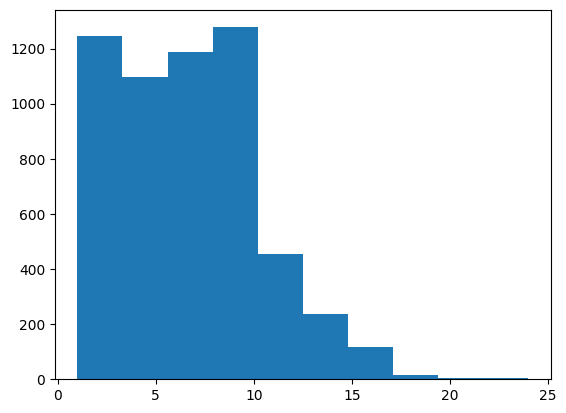

In [10]:
import matplotlib.pyplot as plt

# read the Indian cuisine file to get an estimate of the no of spices per recipe
from statistics import mean
recipe_len = [len(i) for i in cuisinerecipe2spicerecipe_orig.values()]

plt.hist(recipe_len)
print('mean, min and max no of spices in a recipe', mean(recipe_len), min(recipe_len), max(recipe_len))
print(len(recipe_len))

### 3. random (draw from uniform distn) ###

In [11]:
# generate random recipe set that follows the same distribution (of no of ingredients per recipe) as in the Indian cusine data

import random 
s_pool = list(set(list(chain.from_iterable(cuisinerecipe2spicerecipe_orig.values())))) # all spices
# we will randomly generate 5000 recipes and no of ingredients for recipes will be selected based on Indian cuisine
num_recipes = 5636
s_count = [6]*num_recipes
print(mean(s_count), min(s_count), max(s_count))

if GEN_NEW:
    rand_recipes = []
    for k in range(NUM_SETS):
        recipe_random = []
        recipe_random_dict = {} # this will be used in other codes
        for i in range(num_recipes):
            sample = random.sample(s_pool, s_count[i])
            recipe_random.append(sample)
            recipe_random_dict['Recipe{}'.format(i)] = sample
        rand_recipes.append(recipe_random_dict)

    dict2json(rand_recipes,result_folder+ 'randomuniform_recipes.json')
else:
    rand_recipes = json2dict(result_folder+ 'randomuniform_recipes.json') 

6 6 6


## Part 2: min set cover (recipe cover for indications) ##
1. generate recipe2indication bipartite for real recipe data
2. generate recipe2indication bipartite for random recipe 
3. minset cover for each case

### Generate recipe2indic_orig for real recipe ###

In [12]:
#cuisinerecipe2spicerecipe_combined
# generate {cuisinerecipe : indication} dict
def process_name(s):
    return s.lower().replace(' ', '')

spicerecipe2spicehnd = json2dict('Derived_Data/Overlap/spicetarla_spicehnd_dict.json') 
spicehnd2indic = json2dict('Derived_Data/Spice2Phytochemical2Disease/spice2indic_all.json')
spicehnd2indic =  {process_name(k) : v for k, v in spicehnd2indic.items()}

miss = []
cuisinerecipe2indic_orig = {}
for r in cuisinerecipe2spicerecipe_orig.keys():
    indic_list = []
    for s in cuisinerecipe2spicerecipe_orig[r]:
        for s_hnd in spicerecipe2spicehnd[s]:
            try:
                indic_list.extend(spicehnd2indic[process_name(s_hnd)])
            except:
                miss.append(s_hnd)
    cuisinerecipe2indic_orig[r] = list(set(indic_list))
print('MISSING SPICES (appear in spice2recipe but not in spice2indic_phytononzero): \n', set(miss))

MISSING SPICES (appear in spice2recipe but not in spice2indic_phytononzero): 
 set()


In [13]:
# Find recipe-indication for all random recipe-spice sets

miss = []

# copy-mutate uniform
recipe2indic_randuniform_list = []
for idx in range(NUM_SETS):
    recipe2indic_randuniform = {}
    for i in range(len(randuniform_recipes[idx])):
        indic_list = []
        for s in randuniform_recipes[idx]['Recipe'+str(i)]:
            for s_hnd in spicerecipe2spicehnd[s]:
                try:
                    indic_list.extend(spicehnd2indic[process_name(s_hnd)])
                except:
                    miss.append(s_hnd)
        recipe2indic_randuniform['Recipe'+str(i)] = list(set(indic_list))
    recipe2indic_randuniform_list.append(recipe2indic_randuniform)


# copy-mutate freq
miss = []
recipe2indic_randfreq_list = []
for idx in range(NUM_SETS):
    recipe2indic_randfreq = {}
    for i in range(len(randfreq_recipes[idx])):
        indic_list = []
        for s in randfreq_recipes[idx]['Recipe'+str(i)]:
            for s_hnd in spicerecipe2spicehnd[s]:
                try:
                    indic_list.extend(spicehnd2indic[process_name(s_hnd)])
                except:
                    miss.append(s_hnd)
        recipe2indic_randfreq['Recipe'+str(i)] = list(set(indic_list))
    recipe2indic_randfreq_list.append(recipe2indic_randfreq)
    
miss = []

# random uniform
recipe2indic_rand_list = []
for idx in range(NUM_SETS):
    recipe2indic_rand = {}
    for i in range(len(rand_recipes[idx])):
        indic_list = []
        for s in rand_recipes[idx]['Recipe'+str(i)]:
            for s_hnd in spicerecipe2spicehnd[s]:
                try:
                    indic_list.extend(spicehnd2indic[process_name(s_hnd)])
                except:
                    miss.append(s_hnd)
        recipe2indic_rand['Recipe'+str(i)] = list(set(indic_list))
    recipe2indic_rand_list.append(recipe2indic_rand)



### Min Set Cover for each disease category ###
### Be Patient for it to run ###

In [14]:
GEN_MINSET = False

In [15]:
group2indic2spice =  json2dict('Derived_Data/MinSetCover/group2indic2spice.json')

def Minset_recipe_bygroup(recipe2indic, recipe2spice):
    group2minrecipe = {}
    for group, val in group2indic2spice.items():
        print(group)
        indic_select = list(val.keys())
        indic2recipe = reverse_dict(recipe2indic)   #cuisinerecipe2indic_orig

        indic2recipe_sub = {indic: indic2recipe[indic] for indic in indic_select if indic in indic2recipe}
        print('#indic',len(indic_select), '#indic used in recipes:', len(indic2recipe_sub))
        recipe2indic_sub = reverse_dict(indic2recipe_sub) 

       # print(indic2recipe_sub.keys())
        set_name = ['Recipe','Indication']
        bi_graph_sub, recipe_topset_sub, indic_botset_sub = Bipartite_graph(recipe2indic_sub, set_name)
        if recipe_topset_sub and indic_botset_sub:
            adjmtx_sub = bipartite.biadjacency_matrix(bi_graph_sub, row_order=indic_botset_sub, column_order=recipe_topset_sub).toarray()

            n2 = adjmtx_sub.shape[1]
            c = np.hstack([np.ones(n2), [0]])

            min_set_bygroup = Min_cover_set(recipe2indic_sub, recipe_topset_sub, indic_botset_sub, adjmtx_sub, c)
            min_r2s = {}
            for min_r in min_set_bygroup:
                min_r2s[min_r] = recipe2spice[min_r]
            group2minrecipe[group] = min_r2s
    return group2minrecipe
   
if GEN_MINSET:
    # min set for real recipe       
    group2minrecipe_orig = Minset_recipe_bygroup(cuisinerecipe2indic_orig,cuisinerecipe2spicerecipe_orig)
    dict2json(group2minrecipe_orig, result_folder + 'group2minrecipe_orig.json')

    # min set for copy-mutate uniform
    group2minrecipe_randuniform_list = []
    for idx in range(NUM_SETS):
        group2minrecipe_randuniform = Minset_recipe_bygroup(recipe2indic_randuniform_list[idx],randuniform_recipes[idx])
        group2minrecipe_randuniform_list.append(group2minrecipe_randuniform)
    dict2json(group2minrecipe_randuniform_list, result_folder + 'group2minrecipe_randuniform_list.json')

    # min set for copy-mutate freq conserve
    group2minrecipe_randfreq_list = []
    for idx in range(NUM_SETS):
        group2minrecipe_randfreq = Minset_recipe_bygroup(recipe2indic_randfreq_list[idx],randfreq_recipes[idx])
        group2minrecipe_randfreq_list.append(group2minrecipe_randfreq)
    dict2json(group2minrecipe_randfreq_list, result_folder + 'group2minrecipe_randfreq_list.json')

    # min set for random uniform recipes
    group2minrecipe_rand_list = []
    for idx in range(NUM_SETS):
        group2minrecipe_rand = Minset_recipe_bygroup(recipe2indic_rand_list[idx],rand_recipes[idx])
        group2minrecipe_rand_list.append(group2minrecipe_rand)
    dict2json(group2minrecipe_rand_list, result_folder + 'group2minrecipe_rand_list.json')
else:
    group2minrecipe_orig = json2dict(result_folder + 'group2minrecipe_orig.json')
    group2minrecipe_randuniform_list = json2dict(result_folder + 'group2minrecipe_randuniform_list_100.json')
    group2minrecipe_randfreq_list = json2dict(result_folder + 'group2minrecipe_randfreq_list_100.json')
    group2minrecipe_rand_list = json2dict(result_folder + 'group2minrecipe_rand_list_100.json')

In [16]:
print(len(group2minrecipe_rand_list))
print(group2minrecipe_rand_list[2] == group2minrecipe_rand_list[3])
print(group2minrecipe_rand_list[30]['infectious_disease'] == group2minrecipe_rand_list[20]['infectious_disease'])

100
False
False


In [17]:
groups_select = ['infectious_disease', 
                 'gastrointestinal_disease',
                 'cancer_disease',
                 'skin_disease',
                 'nephrological_disease',
                 'neuronal_disease',
                 'respiratory_disease',
                 'pregnancy_disease',
                 'mental_disease',
                 'metabolic_disease',
                 'cardiovascular_disease',
                 'immune_disease'
]

## Box plots by disease category ##

/var/folders/b4/v914vnr53d78831b3prx5h680000gn/T/ipykernel_4380/386855270.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['FC-CM','U-CM','RU'],fontsize=16)


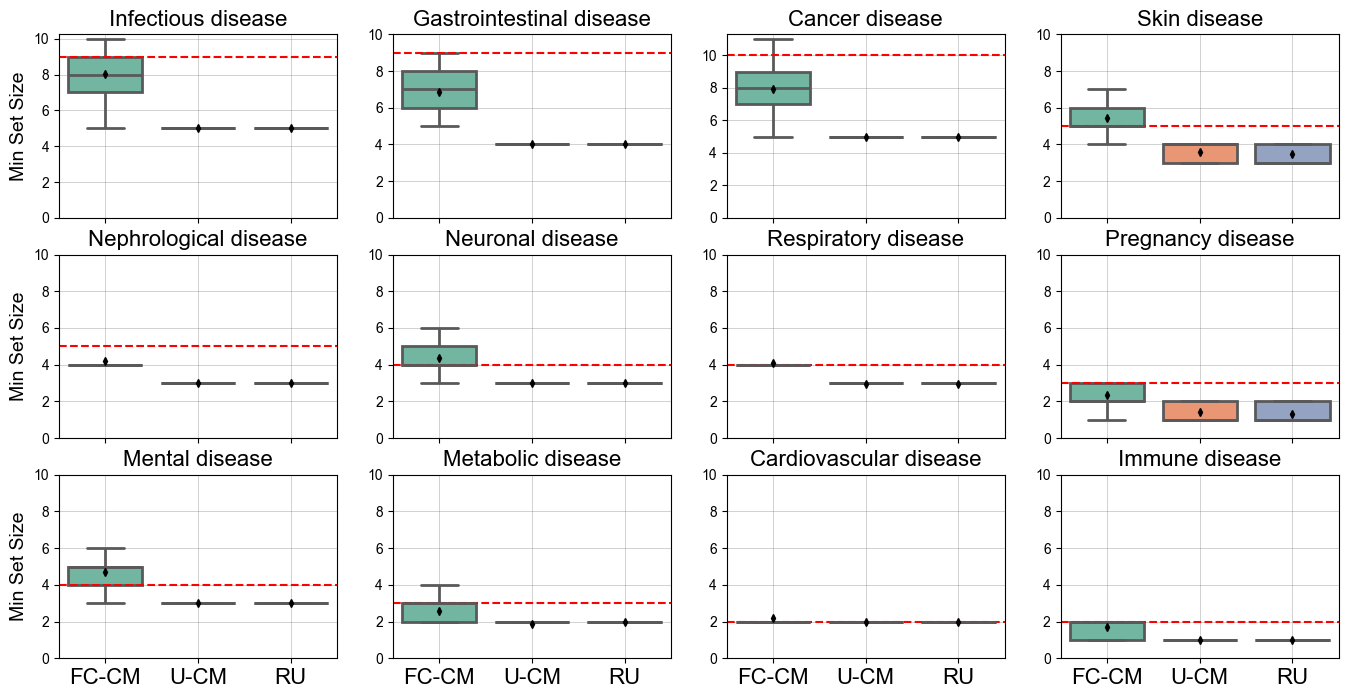

In [18]:
# FINAL 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

num_set = len(group2minrecipe_randfreq_list)

num_show = 0

fig, axes = plt.subplots(3, 4, sharex=True, figsize=(16,8))

for count_temp11, group in enumerate(groups_select):
    count_orig, countlist_orig, countlist_randfreq, countlist_randuniform, countlist_rand = [],[],[],[],[]
    count_multi_df = []
    orig_count = len(group2minrecipe_orig[group]) # just one set 
    for i in range(num_set):
        countlist_randfreq.append({'count':len(group2minrecipe_randfreq_list[i][group]), 'type':'frequency-conserved copy mutate'})
        countlist_randuniform.append({'count':len(group2minrecipe_randuniform_list[i][group]), 'type':'uniform copy mutate'})
        countlist_rand.append({'count':len(group2minrecipe_rand_list[i][group]), 'type':'random uniform'})
    count_multi_df.extend(countlist_randfreq)
    count_multi_df.extend(countlist_randuniform)
    count_multi_df.extend(countlist_rand)

    count_multi_df = pd.DataFrame(count_multi_df)

    sns.set_style("dark", {"axes.facecolor": ".9"})

    ax =sns.boxplot(x ='type', y='count', hue='type', ax = axes[int(num_show/4),num_show%4], 
                    data=count_multi_df, palette="Set2", showmeans=True, showfliers=False,linewidth=2, 
                   meanprops={"marker":"d",
                       "markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"4"})
    ax.axhline(y=orig_count, color='r', linestyle='--')
    ax.set_xticklabels(['FC-CM','U-CM','RU'],fontsize=16)
    ax.set_xticks(np.arange(0,3,1))
    ax.set_yticks(np.arange(0,12,2))
    ax.set_xlabel('', fontsize=1)
    ax.set_ylabel('', fontsize=14)
    if (count_temp11%4 ==0):
        ax.set_ylabel('Min Set Size', fontsize=14)
    ax.set_title(' '.join(group.split('_')).capitalize(), fontsize=16)
    ax.legend([],[], frameon=False)
    
    # Add grid to the subplot
    ax.grid(True, linewidth=0.5, color='gray', linestyle='-', alpha=0.5)
    
    num_show +=1 
    if num_show > 11:
        break

fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)  # create some space below the plots by increasing the bottom-value

# Check if there are any legend texts before modifying them
if len(axes.flatten()[-3].get_legend_handles_labels()[1]) > 0:
    L = axes.flatten()[-3].legend(loc='upper center', bbox_to_anchor=(1.1, -0.5), ncol=3, fontsize=16)
    legend_texts = L.get_texts()
    if len(legend_texts) >= 3:
        legend_texts[0].set_text('Frequency Conserved Copy Mutate (FC-CM)')
        legend_texts[1].set_text('Uniform Copy Mutate (U-CM)')
        legend_texts[2].set_text('Random uniform (RU)')

plt.savefig(result_folder+'Boxplot_minsetcover_disease.png', bbox_inches="tight", dpi = 600)

plt.show()